## Assignment: Object detection
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
*	Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
*	Put into practice acquired knowledge to optimize the parameters and architecture of a feed-forward Neural Net (ffNN), in the context of an image recognition problem.
*	Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous image classification task.
*	Understand how to modify previous classification NNs for detecting objects. Build an object detector based on a sliding window, single-stage, or two-stage strategy.

Follow the link below to download the detection data set “xview_detection”: [https://drive.upm.es/s/JTaa6pKTRSQDAlw](https://drive.upm.es/s/JTaa6pKTRSQDAlw)

In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category = -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {13: 'CARGO_PLANE', 15: 'HELICOPTER', 18: 'SMALL_CAR', 19: 'BUS', 23: 'TRUCK', 41: 'MOTORBOAT', 47: 'FISHING_VESSEL', 60: 'DUMP_TRUCK', 64: 'EXCAVATOR', 73: 'BUILDING', 86: 'STORAGE_TANK', 91: 'SHIPPING_CONTAINER'}

In [ ]:
import warnings
import rasterio
import numpy as np
from PIL import Image

def load_database_txt(anns_file):
    pos = anns_file.rfind('/') + 1
    path = anns_file[:pos]
    with open(anns_file, 'r', encoding='utf-8') as ifs:
        lines = ifs.readlines()
        anns = []
        for i in range(len(lines)):
            parts = lines[i].strip().split(';')
            if parts[0] == '#' or parts[0] == '@':
                continue
            anns.append(load_filename(path, lines[i]))
    ifs.close()
    return anns

def load_filename(path, line):
    parts = line.strip().split(';')
    image = GenericImage(path + parts[0])
    num_predictions = int(parts[1])
    width, height = Image.open(image.filename).size
    image.tile = np.array([0, 0, width, height])
    image.gsd = 0.3
    for idx in range(0, num_predictions):
        obj = GenericObject()
        obj.id = int(parts[(3*idx)+2])
        pts = parts[(3*idx)+3].split(',')
        obj.bb = (int(pts[0]), int(pts[1]), int(pts[2]), int(pts[3]))
        cat = int(parts[(3*idx)+4])
        if cat not in categories.keys():
            continue
        obj.category = categories[cat]
        obj.score = 1.0
        image.add_object(obj)
    return image

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [ ]:
import os
import sys
sys.path.append(os.getcwd())

tile_shape = (800, 800)
overlap_shape = (200, 200)
path = './'
pretrained_model = 'resnet_v1_101'
model_name = 'XView_SCRDet19'
gpu = [0]
print('CPU mode' if -1 in gpu else 'GPU mode with devices ' + str(gpu))
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu[0])

GPU mode with devices [0]


#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [ ]:
import os

# Load database
anns_file = '../../xview_detection/xview_ann_test.txt'
print('Open annotations file: ' + str(anns_file))
if os.path.isfile(anns_file):
    anns = load_database_txt(anns_file)
else:
    raise ValueError('Annotations file does not exist')
print('Number of testing images: ' + str(len(anns)))

Open annotations file: ../../xview_detection/xview_ann_test.txt
Number of testing images: 83


In [ ]:
import tensorflow as tf
from ... import build_network

# Set up a neural network to train
print('Load model')
model = build_network(base_network_name=pretrained_model, is_training=False)
input = tf.placeholder(dtype=tf.float32, shape=[None, None, None, 3])  # RGB
output = model.process(input_img_batch=input, num_classes=len(categories)+1)
sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)
restorer, restore_ckpt = model.get_restorer(path, model_name, pretrained_model)
if restorer is not None:
    restorer.restore(sess, restore_ckpt)

Load model


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    

Model restore from checkpoint: images_framework/detection/scrdet19_detecti

In [ ]:
import numpy as np

def py_cpu_nms(dets, thresh, max_output_size):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        if len(keep) >= max_output_size:
            break
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]
    return np.array(keep, np.int64)

In [ ]:
from tqdm.notebook import tqdm

threshold = {'CARGO_PLANE': 0.5, 'HELICOPTER': 0.5, 'SMALL_CAR': 0.5, 'BUS': 0.5, 'TRUCK': 0.5, 'MOTORBOAT': 0.5, 'FISHING_VESSEL': 0.5, 'DUMP_TRUCK': 0.5, 'EXCAVATOR': 0.5, 'BUILDING': 0.5, 'STORAGE_TANK': 0.5, 'SHIPPING_CONTAINER': 0.5}
annotations, predictions = {}, {}
for img_pred in tqdm(anns, file=sys.stdout):
    # Save annotations
    annotations.setdefault(img_pred.filename, {})
    predictions.setdefault(img_pred.filename, {})
    for obj in img_pred.objects:
        annotations[img_pred.filename].setdefault(obj.category, {'bbox': []})
        annotations[img_pred.filename][obj.category]['bbox'].append(obj.bb)
    # Load image
    img = load_geoimage(img_pred.filename)
    # Add black border
    input_image_pad = np.zeros([img.shape[0]+tile_shape[0], img.shape[1]+tile_shape[1], 3], np.uint8)
    input_image_pad[0:img.shape[0], 0:img.shape[1], :] = img
    img = input_image_pad
    # Sliding window
    box_res, label_res, score_res = [], [], []
    for hh in range(0, img.shape[0], tile_shape[0]-overlap_shape[0]):
        for ww in range(0, img.shape[1], tile_shape[1]-overlap_shape[1]):
            src_tile = (ww, hh, ww+tile_shape[1], hh+tile_shape[0])
            batch_imgs = img[src_tile[1]:src_tile[3], src_tile[0]:src_tile[2], :]
            batch_imgs = np.array(batch_imgs, dtype=np.float32)
            batch_imgs = np.expand_dims(batch_imgs, axis=0)
            det_boxes_h, det_scores_h, det_category_h, det_boxes_r, det_scores_r, det_category_r = sess.run(output, feed_dict={input: batch_imgs})
            # Save predictions in order to apply NMS
            for idx in range(len(det_boxes_h)):
                box_res.append((det_boxes_h[idx][0]+ww, det_boxes_h[idx][1]+hh, det_boxes_h[idx][2]+ww, det_boxes_h[idx][3]+hh))
                label_res.append(categories[int(det_category_h[idx])])
                score_res.append(float(det_scores_h[idx]))
    box_res = np.array(box_res)
    label_res = np.array(label_res)
    score_res = np.array(score_res)
    # Apply NMS
    for key in threshold.keys():
        indices = np.where(label_res == key)[0]
        if len(indices) == 0:
            continue
        tmp_boxes_h = box_res[indices]
        tmp_label_h = label_res[indices]
        tmp_score_h = score_res[indices]
        tmp_boxes_h = np.array(tmp_boxes_h)
        tmp = np.zeros([tmp_boxes_h.shape[0], tmp_boxes_h.shape[1]+1])
        tmp[:, 0:-1] = tmp_boxes_h
        tmp[:, -1] = np.array(tmp_score_h)
        indices = py_cpu_nms(dets=np.array(tmp, np.float32), thresh=threshold[key], max_output_size=10000)
        # Save prediction
        predictions[img_pred.filename].setdefault(key, {'bbox': [], 'confidence': []})
        for idx in range(len(tmp_boxes_h[indices])):
            obj = GenericObject()
            obj.bb = (tmp_boxes_h[indices][idx][0], tmp_boxes_h[indices][idx][1], tmp_boxes_h[indices][idx][2], tmp_boxes_h[indices][idx][3])
            obj.category = tmp_label_h[indices][idx]
            obj.score = tmp_score_h[indices][idx]
            predictions[img_pred.filename][obj.category]['bbox'].append(obj.bb)
            predictions[img_pred.filename][obj.category]['confidence'].append(obj.score)  # sort detections by confidence

  0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
def area_intersection(boxes, box):
    xmin = np.maximum(np.min(boxes[:, 0::2], axis=1), np.min(box[0::2]))
    ymin = np.maximum(np.min(boxes[:, 1::2], axis=1), np.min(box[1::2]))
    xmax = np.minimum(np.max(boxes[:, 0::2], axis=1), np.max(box[0::2]))
    ymax = np.minimum(np.max(boxes[:, 1::2], axis=1), np.max(box[1::2]))
    w = np.maximum(xmax - xmin + 1.0, 0.0)
    h = np.maximum(ymax - ymin + 1.0, 0.0)
    return w * h

def area_union(boxes, box):
    area_anns = (np.max(box[0::2])-np.min(box[0::2])+1.0) * (np.max(box[1::2])-np.min(box[1::2])+1.0)
    area_pred = (np.max(boxes[:, 0::2], axis=1)-np.min(boxes[:, 0::2], axis=1)+1.0) * (np.max(boxes[:, 1::2], axis=1)-np.min(boxes[:, 1::2], axis=1)+1.0)
    return area_anns + area_pred - area_intersection(boxes, box)

def calc_iou(boxes, box):
    iou = area_intersection(boxes, box) / area_union(boxes, box)
    max_value = np.max(iou)
    max_index = np.argmax(iou)
    return max_value, max_index

def calc_ap(rec, prec):
    # First append sentinel values at the end
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    # Compute the precision envelope
    for i in range(mpre.size-1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    # To calculate area under PR curve, look for points where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]
    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i+1] - mrec[i]) * mpre[i+1])
    return ap

In [ ]:
threshold = 0.5
default_cls = 'BACKGROUND'
y_true, y_pred = [], []  # confusion matrix
tps, confidences = dict(), dict()  # draw precision-recall curves for each category
for cls in categories.values():
    # Compute TP, FP and FN for each image
    tps[cls], confidences[cls] = [], []
    for f in predictions:
        # Sort 'cls' predictions by confidence for each file
        pred_boxes, pred_confidences = [], []
        if cls in predictions[f].keys():
            for idx in range(len(predictions[f][cls]['bbox'])):
                pred_boxes.append(predictions[f][cls]['bbox'][idx])
                pred_confidences.append(predictions[f][cls]['confidence'][idx])
            sorted_ind = np.argsort(-np.array(pred_confidences))
            pred_boxes = np.array(pred_boxes)[sorted_ind, :]
        pred_boxes = np.array(pred_boxes).astype(float)
        # Define 'cls' annotations for each file
        anno_boxes = []
        if cls in annotations[f].keys():
            anno_boxes = annotations[f][cls]['bbox']
        anno_boxes = np.array(anno_boxes).astype(float)
        # Define horizontal or oriented bounding boxes
        anno_indices = list(range(len(anno_boxes)))
        # Compare a single prediction 'pred_box' with all annotations 'anno_boxes'
        for pred_idx, pred_box in enumerate(pred_boxes):
            # A prediction is correct if its IoU with the ground truth is above the threshold
            iou_value, ann_index = calc_iou(anno_boxes, pred_box) if len(anno_boxes) > 0 else (-1, -1)
            if iou_value > threshold and ann_index in anno_indices:
                # TP
                anno_indices.remove(int(ann_index))
                tps[cls] += [1.0]
                y_true += [cls]
            else:
                # FP
                tps[cls] += [0.0]
                y_true += [default_cls]
            y_pred += [cls]
            confidences[cls] += [pred_confidences[pred_idx]]
        # FN
        y_true += [cls] * len(anno_indices)
        y_pred += [default_cls] * len(anno_indices)
y_true, y_pred = np.array(y_true), np.array(y_pred)

In [ ]:
import matplotlib.pyplot as plt

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

Confusion matrix:
[[    0    35    10  5802    97   134    65    20    54   117  8051    62
     10]
 [   21    69     0     0     0     0     0     0     0     0     0     0
      0]
 [   16     0     6     0     0     0     0     0     0     0     0     0
      0]
 [12076     0     0  4451     0     0     0     0     0     0     0     0
      0]
 [  388     0     0     0    38     0     0     0     0     0     0     0
      0]
 [ 1491     0     0     0     0    58     0     0     0     0     0     0
      0]
 [  196     0     0     0     0     0    36     0     0     0     0     0
      0]
 [   56     0     0     0     0     0     0     7     0     0     0     0
      0]
 [  102     0     0     0     0     0     0     0    18     0     0     0
      0]
 [   77     0     0     0     0     0     0     0     0    63     0     0
      0]
 [23028     0     0     0     0     0     0     0     0     0 10153     0
      0]
 [  134     0     0     0     0     0     0     0     0     0     0  

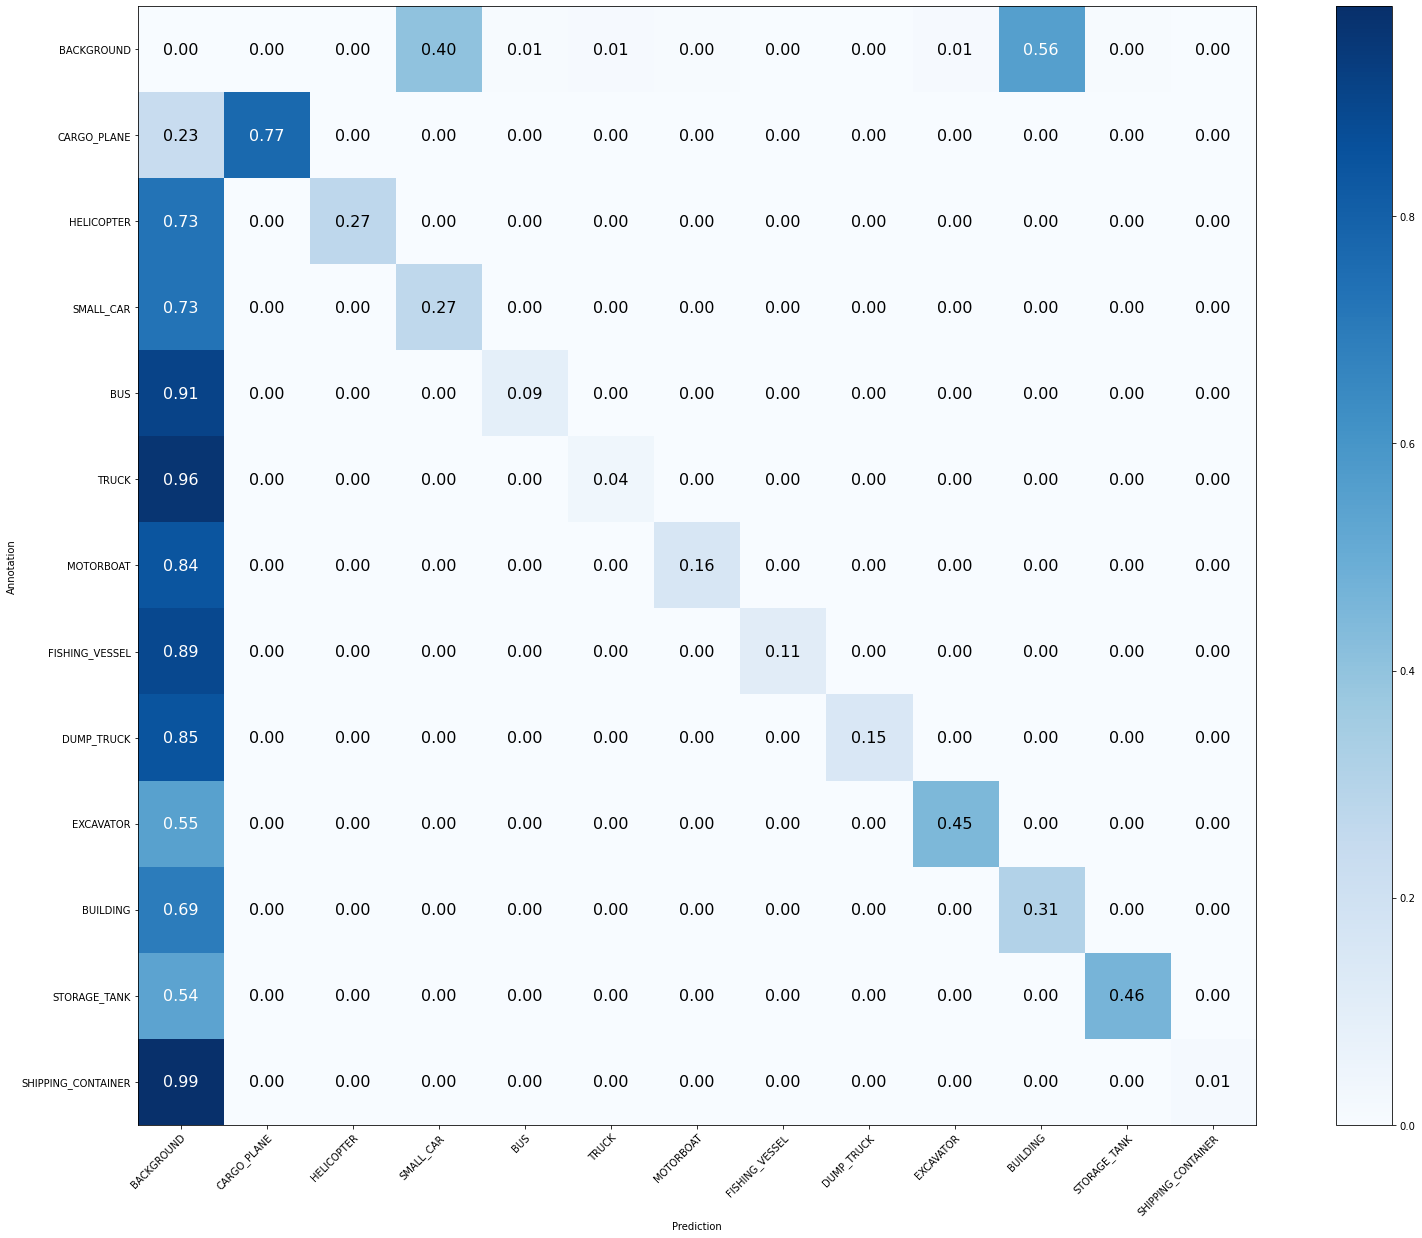

In [ ]:
from sklearn.metrics import confusion_matrix

names = list(categories.values())
names.insert(0, default_cls)
cm = confusion_matrix(y_true, y_pred, labels=names)
print('Confusion matrix:')
print(cm)
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
print('Pixel Acc: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Acc: %.3f%%' % (acc.mean() * 100))
for idx, val in enumerate(names):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (val, recall*100, precision*100, specificity*100, f1_score*100))
draw_confusion_matrix(cm, names)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as col

def draw_precision_recall(precisions, recalls, categories):
    # Draw precision-recall curves for each category
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    plt.axis([0, 1, 0, 1])
    c_dark = list(filter(lambda x: x.startswith('dark'), col.cnames.keys()))
    aps = []
    # Compare categories for a specific algorithm
    for idx in range(len(categories)):
        plt.plot(recalls[idx], precisions[idx], color=c_dark[idx], label=categories[idx], linewidth=4.0)
        aps.append(calc_ap(recalls[idx], precisions[idx]))
    handles, labels = ax.get_legend_handles_labels()
    labels = [str(val + ' [' + "{:.3f}".format(aps[idx]) + ']') for idx, val in enumerate(labels)]
    handles = [h for (ap, h) in sorted(zip(aps, handles), key=lambda x: x[0], reverse=True)]
    labels = [l for (ap, l) in sorted(zip(aps, labels), key=lambda x: x[0], reverse=True)]
    leg = plt.legend(handles, labels, loc='upper right')
    leg.set_zorder(100)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid("on", linestyle="--", linewidth=2.0)
    fig.tight_layout()
    plt.show(fig)

> CARGO_PLANE: Recall: 76.667% Precision: 66.346% AP: 69.301%
> HELICOPTER: Recall: 27.273% Precision: 37.500% AP: 22.609%
> SMALL_CAR: Recall: 26.932% Precision: 43.412% AP: 15.726%
> BUS: Recall: 8.920% Precision: 28.148% AP: 3.780%
> TRUCK: Recall: 3.744% Precision: 30.208% AP: 1.886%
> MOTORBOAT: Recall: 15.517% Precision: 35.644% AP: 9.071%
> FISHING_VESSEL: Recall: 11.111% Precision: 25.926% AP: 4.299%
> DUMP_TRUCK: Recall: 15.000% Precision: 25.000% AP: 6.190%
> EXCAVATOR: Recall: 45.000% Precision: 35.000% AP: 31.088%
> BUILDING: Recall: 30.599% Precision: 55.773% AP: 22.291%
> STORAGE_TANK: Recall: 46.400% Precision: 65.169% AP: 39.458%
> SHIPPING_CONTAINER: Recall: 1.493% Precision: 9.091% AP: 1.493%
mAP: 18.933%


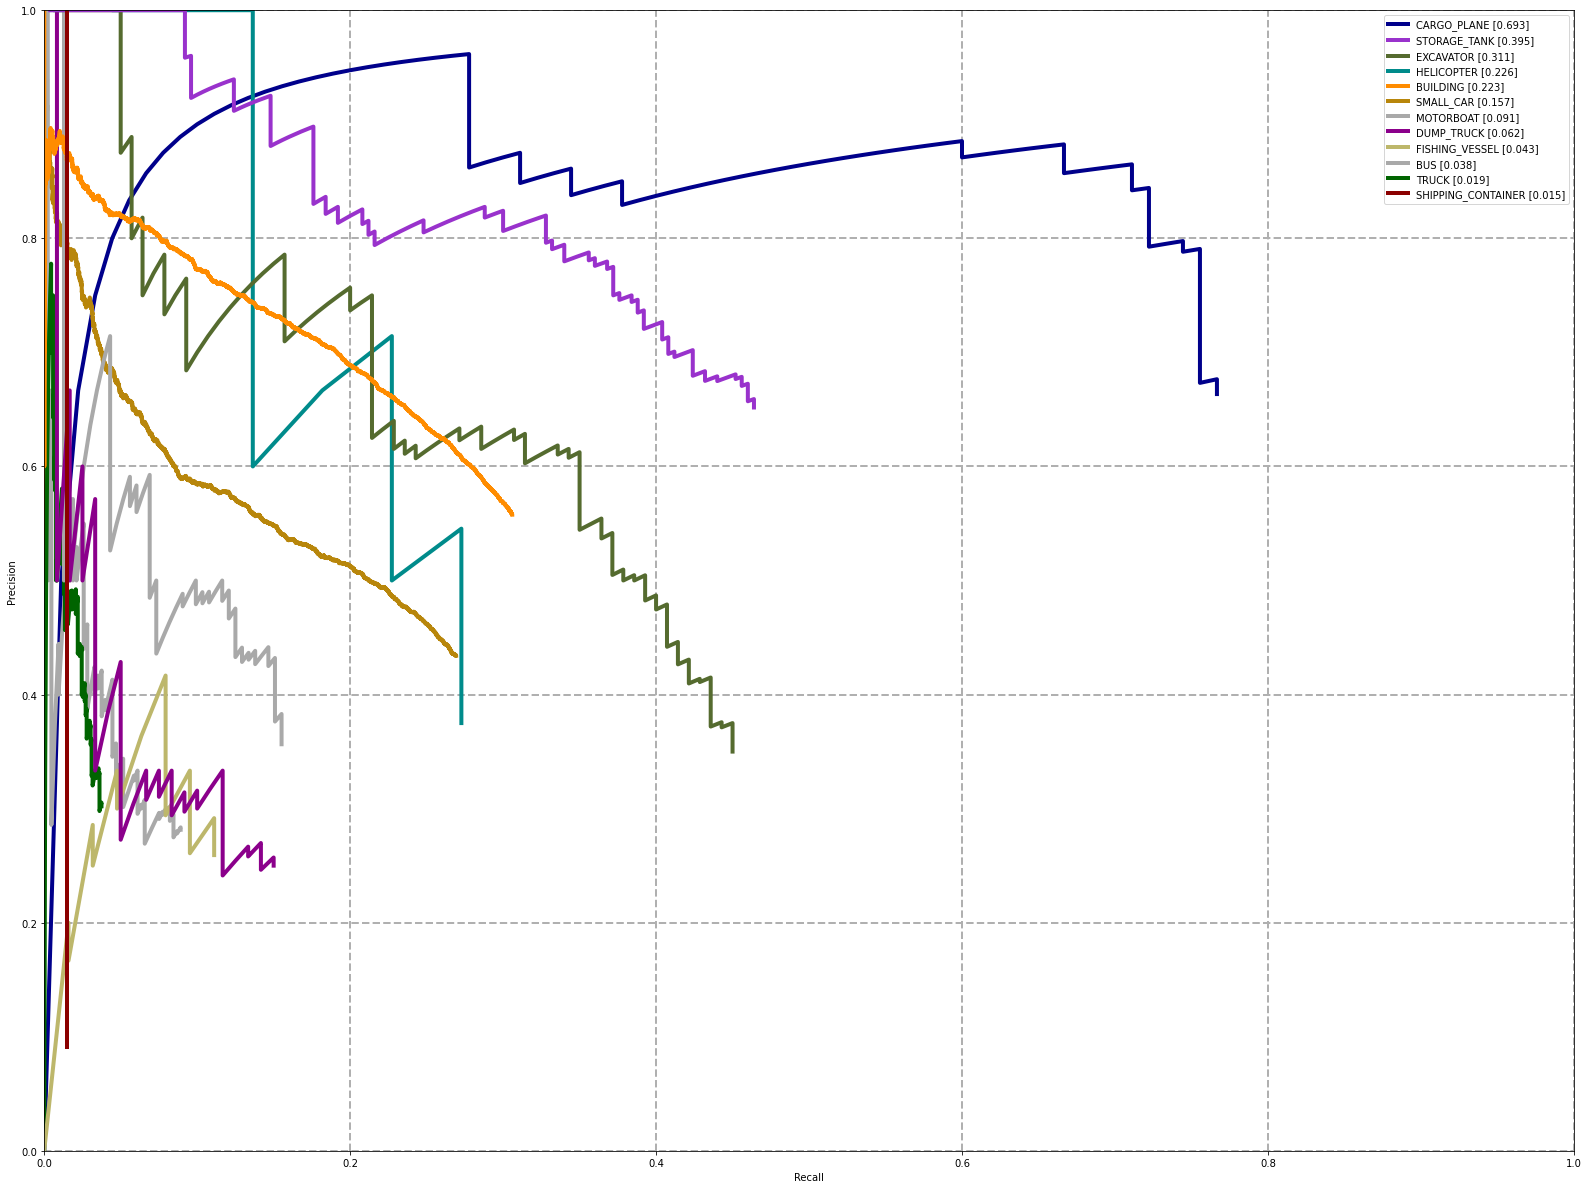

In [ ]:
# Compute AP metric
precision_list, recall_list, ap_list = [], [], []
for cls in categories.values():
    sorted_ind = np.argsort(-np.array(confidences[cls]))
    tp = np.cumsum(np.array(tps[cls])[sorted_ind], dtype=float)
    recall = np.array([0.0]) if len(tp) == 0 else tp / np.maximum(np.sum(y_true == cls), np.finfo(np.float64).eps)
    precision = np.array([0.0]) if len(tp) == 0 else tp / np.maximum(list(range(1, np.sum(y_pred == cls)+1)), np.finfo(np.float64).eps)
    ap = calc_ap(recall, precision)
    print('> %s: Recall: %.3f%% Precision: %.3f%% AP: %.3f%%' % (cls, recall[-1]*100, precision[-1]*100, ap*100))
    precision_list.append(precision)
    recall_list.append(recall)
    ap_list.append(ap)
mean_ap = np.mean(ap_list)
print('mAP: %.3f%%' % (mean_ap*100))
draw_precision_recall(precision_list, recall_list, list(categories.values()))

#### Report
You must prepare a report (.pdf) describing:
*	The problems and data sets (briefly).
*	The process that you have followed to reach your final solution on both detection and classification tasks, including your intermediate results. You must discuss and compare these results properly.
*	Final network architectures, including optimization algorithm, regularization methods (dropout, data augmentation, etc…), number of layers / parameters, and performance obtained with your model on the testing data set, including the plots of the evolution of losses and accuracy performances on both data sets.
*	It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students maximum. Each team must submit one submission before Monday, January 23rd, 2023, 09:55 (am).
